# Mapping precipitation data with geopandas

In this notebook, we explore one of the datasets from the Climate Prediction Center, and attempt to map mean monthly precipitations from the years 1990 to 2021 <br>
Source of data: https://psl.noaa.gov/data/gridded/data.cmap.html#detail

--------------------

## Creating the gridded monthly precipitations (mean) dataset
Since the file formats are in .netcdf4 format (N-Dimensional gridded data), we resort to xarray, which integrates dask for parallel computing and faster processing

In [1]:
# for processing data:
import netCDF4
import numpy as np
import os
import pandas as pd
import time
import xarray as xr
from fsspec.implementations.http import HTTPFileSystem

# for mapping data:
%matplotlib inline
import geopandas
import folium
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify
import h5netcdf
from global_land_mask import globe # for determining coordinates at ocean/land

In [2]:
# importing CPC dataset of daily max temperatures

url = 'https://downloads.psl.noaa.gov/Datasets/cmap/std/precip.mon.mean.nc'
fs = HTTPFileSystem() 
fobj = fs.open(url)

xr_noaa = xr.open_dataset(fobj, chunks={'lat':360, 'lon':720})

In [3]:
xr_noaa

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 527)
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-11-01
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(527, 72, 144), meta=np.ndarray>
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2212
    history:        update 12/2022 V2212
    data_modified:  2022-12-15

**Disclaimer:** immediately converting xarray to pandas DataFrame is not recomended for very high dimensional datasets - for example, I have used gridded daily temperature data, where intermediate steps were needed to use the data

In [4]:
# creating pandas dataframe frop the NETCDF dataset:
df_noaa = xr_noaa.to_dataframe()
prec_df = df_noaa.dropna().reset_index()

In [5]:
prec_df.sample(10)

,lat,lon,time,precip
2180817,11.25,78.75,2006-05-01,2.86
1110334,46.25,41.25,1994-03-01,2.49
1627072,31.25,331.25,2017-05-01,0.52
2210666,11.25,221.25,1990-07-01,4.70
1112783,46.25,51.25,2022-08-01,0.01
2895252,-11.25,228.75,1991-08-01,0.69
3436177,-28.75,273.75,2010-03-01,0.15
3858742,-43.75,118.75,2002-10-01,1.32
1036276,48.75,48.75,2014-12-01,0.69
2059096,16.25,221.25,2007-09-01,0.98


In [8]:
# column for year of observation
prec_df['year'] = pd.DatetimeIndex(prec_df['time']).year

In [9]:
prec_df.sample(5)

,lat,lon,time,precip,year
3832932,-41.25,356.25,2003-11-01,1.97,2003
19379,86.25,136.25,1998-01-01,0.01,1998
1024457,51.25,353.75,1996-03-01,2.87,1996
3454560,-31.25,1.25,2005-01-01,0.49,2005
3540858,-33.75,51.25,1994-03-01,3.98,1994


In [10]:
# pairs of latitude and longitude pairs where there are missing observations for any year before 1990:
pairsdrop = prec_df.groupby(['lat','lon'])['year'].min().reset_index()
pairsdrop = pairsdrop[pairsdrop.year>1990].iloc[:,0:2]
pairsdrop = pairsdrop.to_records(index=False)

# set condition:
condition = pd.Series(list(zip(prec_df.lat, prec_df.lon))).isin(pairsdrop)
# drop pairs of latitude and longitude with missing values for some year >=2000
prec_count = prec_df[~condition]

In [11]:
prec_count.sample(10)

,lat,lon,time,precip,year
3667293,-36.25,291.25,1990-06-01,0.44,1990
4797851,-81.25,81.25,2006-08-01,0.03,2006
4538561,-71.25,148.75,2020-01-01,2.34,2020
3952698,-46.25,203.75,2015-04-01,2.42,2015
634164,63.75,301.25,2014-01-01,0.00,2014
3570201,-33.75,191.25,1980-02-01,2.57,1980
625539,63.75,261.25,1997-12-01,0.53,1997
2681454,-3.75,293.75,2005-04-01,11.45,2005
2577580,-1.25,161.25,2000-09-01,2.09,2000
1385923,38.75,268.75,1991-07-01,2.87,1991


In [13]:
#create dataframe with mean monthly precipitation:
prec_count = prec_count[prec_df.year >= 1990] # dropping years before 1990
plot_df = prec_count.groupby(['lon','lat'])["precip"].mean().to_frame().reset_index()
plot_df.sample(5)

C:\Users\ncozz\AppData\Local\Temp\ipykernel_15288\1300582468.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  prec_count = prec_count[prec_df.year >= 1990] # dropping years before 1990


,lon,lat,precip
5051,186.25,11.25,3.454658
8030,301.25,31.25,3.203975
223,8.75,-28.75,0.216101
1397,51.25,16.25,0.209797
3250,118.75,18.75,5.575620


In [14]:
plot_df.shape

(9572, 3)

-------------
## Mapping precipitation data with geopandas:

In [19]:
# for geopandas, we must transform the longitudes from a range of (0, 360) to (-180, 180)
precipitations = plot_df.copy()
precipitations.lon = (precipitations.lon + 180) % 360 - 180

In [20]:
# let us first drop coordinates in the ocean, since they could skew the range and make most 'land' values low
pairsdrop = precipitations[['lat','lon']].to_records(index=False)
condition = [globe.is_land(x.lat, x.lon) for x in pairsdrop]

precipitations = precipitations[condition]

In [21]:
precipitations.precip.var()

2.5907068252563477

In [22]:
# now, for the fun part, let's create the plot with the remaining coordinates:

%matplotlib inline
map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)

geometry = geopandas.points_from_xy(precipitations.lon, precipitations.lat)
geo_df = geopandas.GeoDataFrame(precipitations, geometry=geometry)

C:\Users\ncozz\anaconda3\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Mean monthly precipitations, 1990-2021 (total value)')

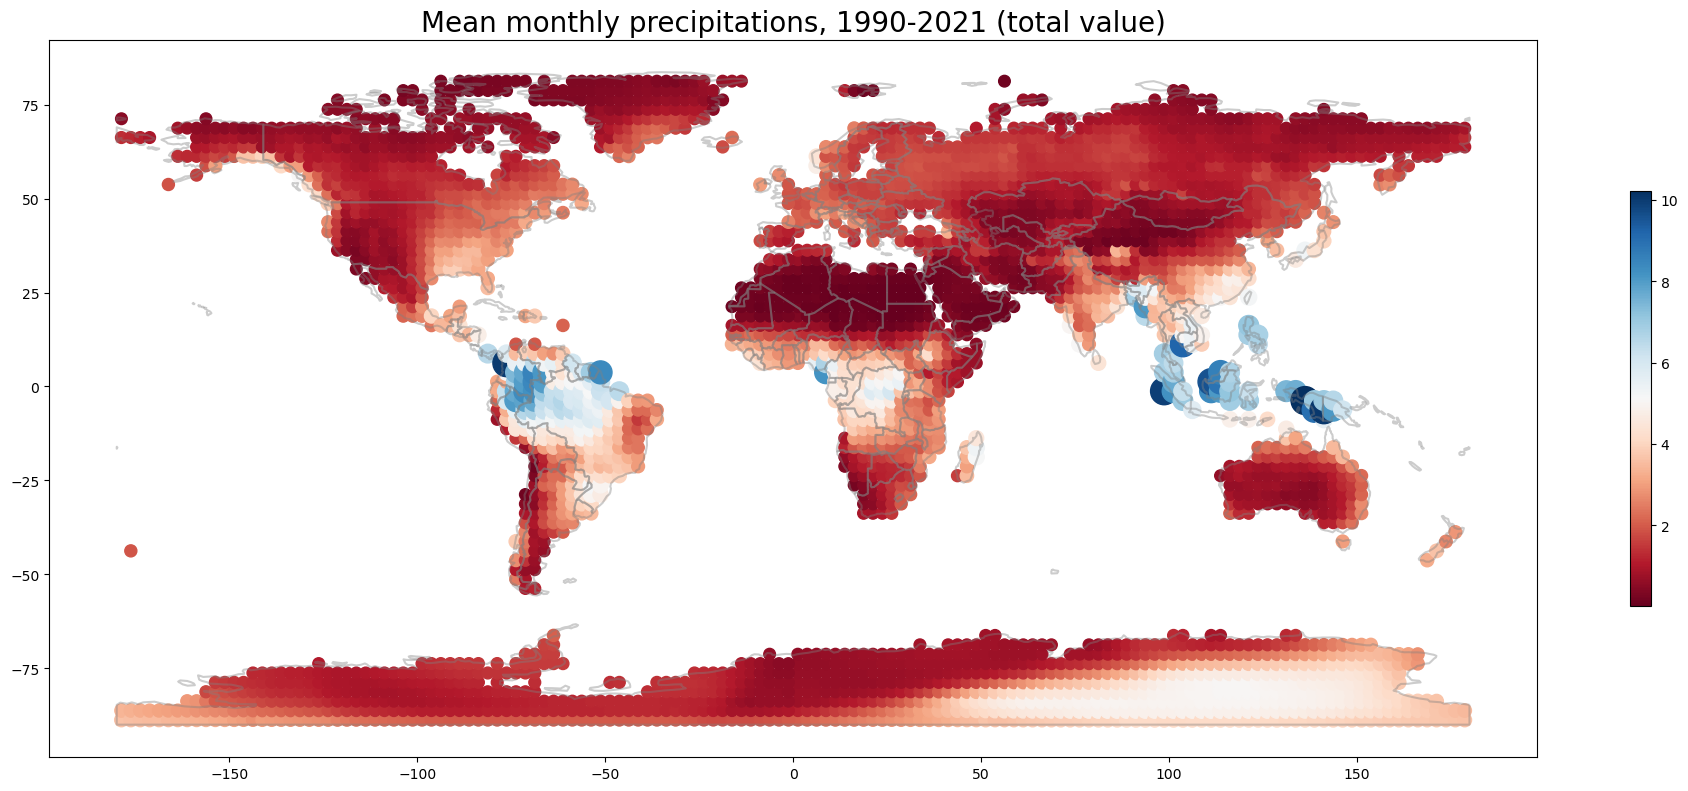

In [23]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(24,18))
world.boundary.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='precip', ax=ax, cmap='RdBu', 
            markersize=(precipitations.precip)**2.5+70,
            legend_kwds={'shrink': 0.3},
            legend=True)
plt.title('Mean monthly precipitations, 1990-2021 (total value)', fontdict={'fontsize':20})

Text(0.5, 1.0, 'Mean monthly precipitations, 1990-2021 (quantile-based)')

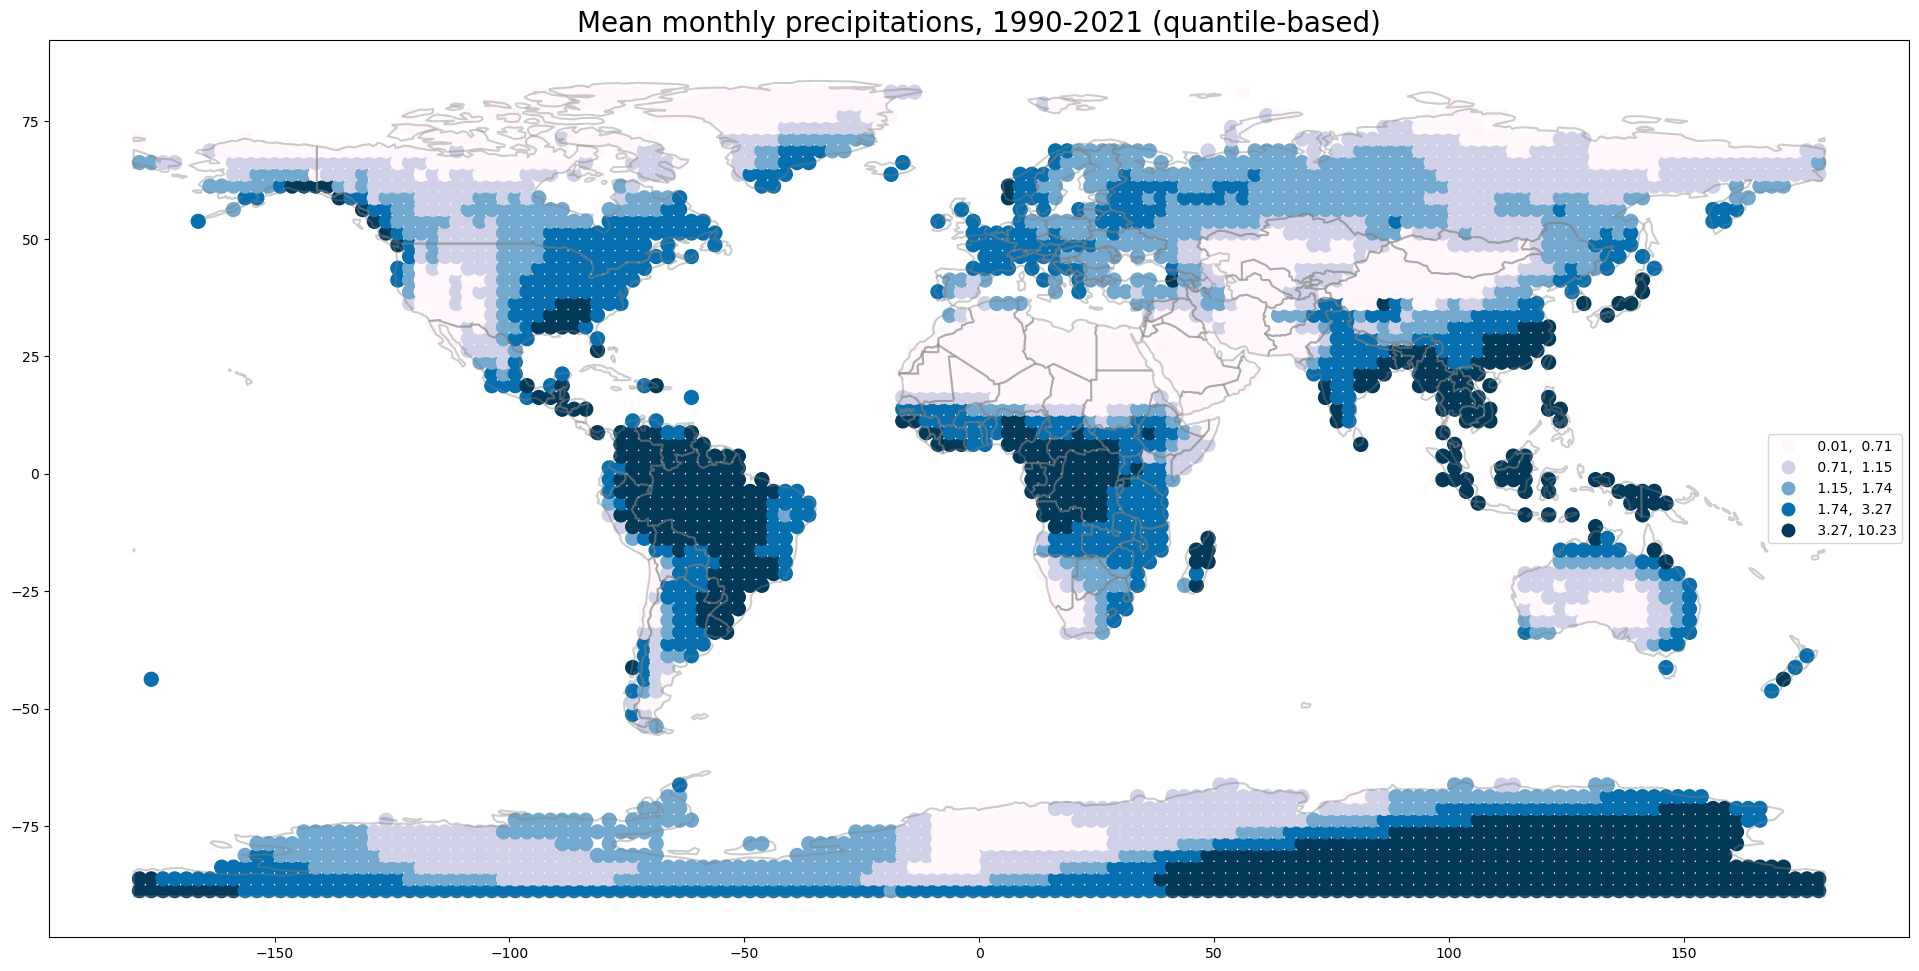

In [25]:
# for quantilesÑ

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(24,18))
world.boundary.plot(ax=ax, alpha=0.4, color='grey')
geo_df.plot(column='precip', ax=ax, cmap='PuBu', 
            scheme='quantiles',
            markersize=100,
            # legend_kwds={'shrink': 0.3},
            legend=True)
plt.title('Mean monthly precipitations, 1990-2021 (quantile-based)', fontdict={'fontsize':20})